In [1]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from sklearn.preprocessing import StandardScaler, normalize, scale
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn import cluster

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

In [2]:
raw_df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
raw_df.shape

(2111, 17)

In [3]:
raw_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
raw_df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Preprocessing

In [5]:
#Renaming columns for easier understanding and reference
raw_df.rename(columns={'FAVC':'frequent_consumption_high_caloric_foods',
                        'FCVC':'frequent_consumption_veggies',
                        'NCP':'number_main_meals',
                        'CAEC':'snacks',
                        'CH2O':'consume_water',
                        'SCC':'monitor_calories',
                        'FAF':'frequency_physical_activity',
                        'TUE':'time_tech_devices',
                        'CALC':'consume_alcohol',
                        'MTRANS':'transportation_type',
                        'NObeyesdad':'obesity_level'},inplace=True)

In [6]:
raw_df.select_dtypes(include=[object]).columns

Index(['Gender', 'family_history_with_overweight',
       'frequent_consumption_high_caloric_foods', 'snacks', 'SMOKE',
       'monitor_calories', 'consume_alcohol', 'transportation_type',
       'obesity_level'],
      dtype='object')

In [7]:
#Label & Ordinal Encoding

columns_to_auto_label_encode = ['Gender', 'family_history_with_overweight',
       'frequent_consumption_high_caloric_foods','SMOKE','monitor_calories','obesity_level']

X = [col for col in raw_df.select_dtypes(include=[object]).columns if col in columns_to_auto_label_encode]

le = preprocessing.LabelEncoder()
df_encoded = raw_df.copy()
print("Mapping for Encoded Values:")
print("")

for col in X:
    le.fit(raw_df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(le_name_mapping)

print("")
print("New dataframe with encoded features:")
for feature in X:
    df_encoded[feature] = le.fit_transform(raw_df[feature])
    
custom_order = ['no', 'Sometimes', 'Always', 'Frequently']
encoder = OrdinalEncoder(categories=[custom_order], dtype=int)
df_encoded['snacks'] = encoder.fit_transform(raw_df[['snacks']])
df_encoded['consume_alcohol'] = encoder.fit_transform(raw_df[['consume_alcohol']])
    
df_encoded.head()

Mapping for Encoded Values:

{'Female': 0, 'Male': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}

New dataframe with encoded features:


,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,consume_water,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,transportation_type,obesity_level
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,Public_Transportation,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,Public_Transportation,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,3,Public_Transportation,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,3,Walking,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,Public_Transportation,6


In [8]:
#OneHotEncoding
df_hotencoded = pd.get_dummies(df_encoded,dtype='int')
df_hotencoded.head()

,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,...,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transportation_type_Automobile,transportation_type_Bike,transportation_type_Motorbike,transportation_type_Public_Transportation,transportation_type_Walking
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0,0.0,1.0,0,1,0,0,0,1,0
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,1,3.0,0.0,1,1,0,0,0,1,0
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,0,2.0,1.0,3,1,0,0,0,1,0
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,0,2.0,0.0,3,5,0,0,0,0,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0,0.0,0.0,1,6,0,0,0,1,0


In [9]:
correlation_matrix = df_hotencoded.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm')

,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,consume_water,monitor_calories,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transportation_type_Automobile,transportation_type_Bike,transportation_type_Motorbike,transportation_type_Public_Transportation,transportation_type_Walking
Gender,1.000000,0.048394,0.618466,0.161668,0.102512,0.064934,-0.274505,0.067600,-0.126272,0.044698,0.107930,-0.102633,0.189607,0.017269,0.002995,0.024908,0.137560,0.057001,0.045203,-0.160184,0.039317
Age,0.048394,1.000000,-0.025958,0.202560,0.205725,0.063902,0.016291,-0.043944,-0.108620,0.091987,-0.045304,-0.116283,-0.144938,-0.296931,0.061564,0.236170,0.604683,0.003652,0.020286,-0.554448,-0.063064
Height,0.618466,-0.025958,1.000000,0.463136,0.247684,0.178364,-0.038121,0.243672,-0.092776,0.055499,0.213376,-0.133753,0.294709,0.051912,0.121672,0.038986,0.077851,0.028996,-0.010471,-0.089684,0.036951
Weight,0.161668,0.202560,0.463136,1.000000,0.496820,0.272300,0.216125,0.107469,-0.357483,0.025746,0.200575,-0.201906,-0.051436,-0.071561,0.161257,0.387643,-0.013619,-0.021745,-0.037300,0.059332,-0.100805
family_history_with_overweight,0.102512,0.205725,0.247684,0.496820,1.000000,0.208036,0.040372,0.071370,-0.228038,0.017385,0.147437,-0.185422,-0.056673,0.022943,-0.037453,0.313667,0.099327,-0.015435,-0.051011,-0.058927,-0.067076
frequent_consumption_high_caloric_foods,0.064934,0.063902,0.178364,0.272300,0.208036,1.000000,-0.027283,-0.007000,-0.176748,-0.050660,0.009719,-0.190658,-0.107995,0.068417,0.058055,0.044582,0.057597,-0.082005,-0.035401,0.028539,-0.179473
frequent_consumption_veggies,-0.274505,0.016291,-0.038121,0.216125,0.040372,-0.027283,1.000000,0.042216,0.064960,0.014320,0.068461,0.071852,0.019939,-0.101135,0.045991,0.018522,-0.061049,-0.029843,-0.007512,0.057966,0.013991
number_main_meals,0.067600,-0.043944,0.243672,0.107469,0.071370,-0.007000,0.042216,1.000000,0.084502,0.007811,0.057088,-0.015624,0.129504,0.036326,0.056082,-0.092616,0.053424,0.023312,0.003875,-0.056849,0.006502
snacks,-0.126272,-0.108620,-0.092776,-0.357483,-0.228038,-0.176748,0.064960,0.084502,1.000000,0.048530,-0.167202,0.110914,0.031367,0.027920,-0.034575,-0.370566,-0.078815,-0.007472,0.082610,0.040873,0.057293
SMOKE,0.044698,0.091987,0.055499,0.025746,0.017385,-0.050660,0.014320,0.007811,0.048530,1.000000,-0.031995,0.047731,0.011216,0.017613,0.098847,-0.023256,0.011873,-0.008416,0.035496,-0.022409,0.017184


Features plotted against Weight


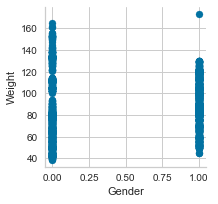

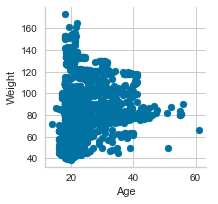

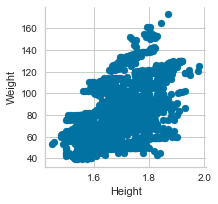

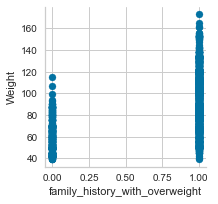

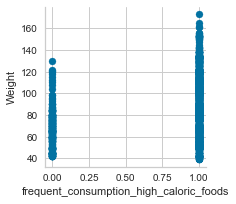

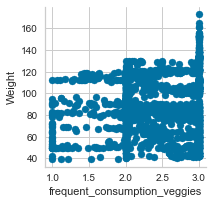

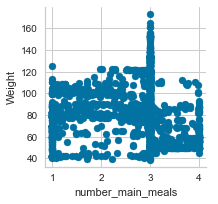

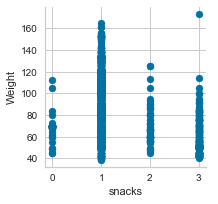

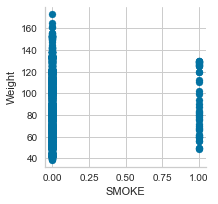

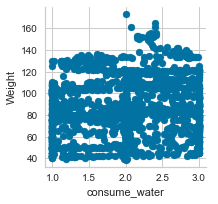

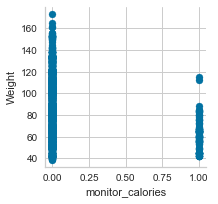

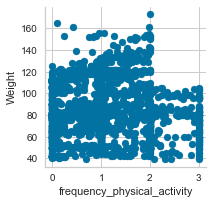

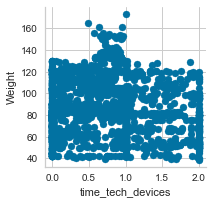

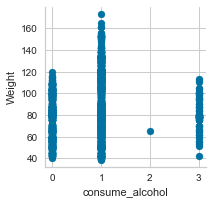

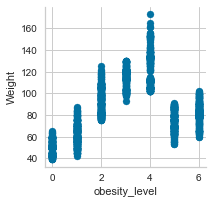

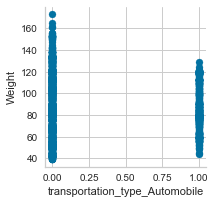

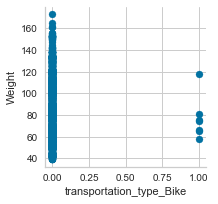

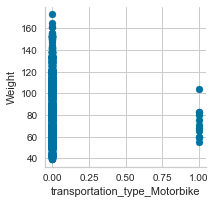

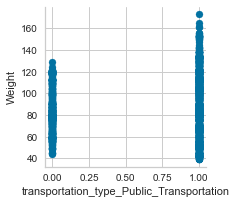

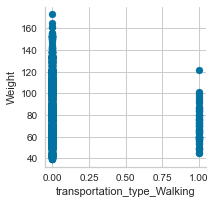

In [10]:
continuous_features = [x for x in df_hotencoded.columns if x not in ['Weight','Cluster ID']]

print("Features plotted against Weight")

for feature in continuous_features:
    fig = sns.FacetGrid(data=df_hotencoded)
    fig.map(plt.scatter,feature, 'Weight').add_legend()

### KMeans

Text(0, 0.5, 'SSE')

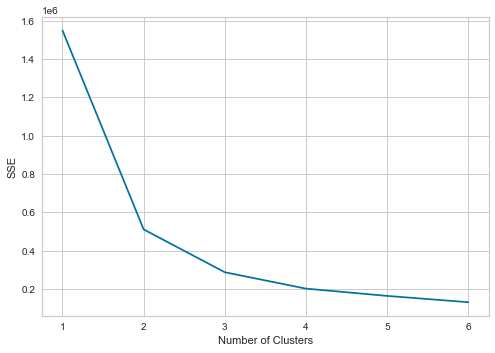

In [11]:
df = df_hotencoded

numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k,n_init=10)
    k_means.fit(df)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [12]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(df) 
labels = k_means.labels_
print("Silhouette Score:",metrics.silhouette_score(df, labels))

df_with_clusters = df.copy()
df_with_clusters['Cluster ID'] = labels
df_with_clusters.head()

Silhouette Score: 0.5645447875594213


,Gender,Age,Height,Weight,family_history_with_overweight,frequent_consumption_high_caloric_foods,frequent_consumption_veggies,number_main_meals,snacks,SMOKE,...,frequency_physical_activity,time_tech_devices,consume_alcohol,obesity_level,transportation_type_Automobile,transportation_type_Bike,transportation_type_Motorbike,transportation_type_Public_Transportation,transportation_type_Walking,Cluster ID
0,0,21.0,1.62,64.0,1,0,2.0,3.0,1,0,...,0.0,1.0,0,1,0,0,0,1,0,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,1,1,...,3.0,0.0,1,1,0,0,0,1,0,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,1,0,...,2.0,1.0,3,1,0,0,0,1,0,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,1,0,...,2.0,0.0,3,5,0,0,0,0,1,1
4,1,22.0,1.78,89.8,0,0,2.0,1.0,1,0,...,0.0,0.0,1,6,0,0,0,1,0,1


In [13]:
new_patient = [0,25,1.80,87.0,1,0,3,3,1,0,2.0,0,1,0,1,0,0,0,0,1,0]
predicted_cluster = k_means.predict([new_patient])
predicted_cluster

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


array([1], dtype=int32)

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


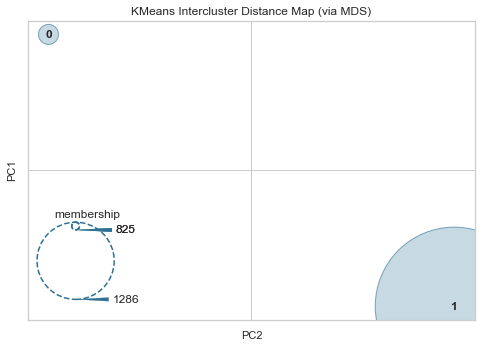

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [14]:
icdm = InterclusterDistance(k_means)

icdm.fit(df)       
icdm.show() 

/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


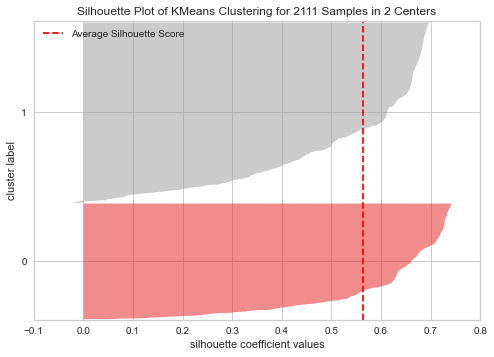

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2111 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
silhouette = SilhouetteVisualizer(k_means)

silhouette.fit(df)        
silhouette.show()  

### Agglomerative Clustering

In [16]:
#scaler = MinMaxScaler()
#df['Weight'] = scaler.fit_transform(df[['Weight']])

Silhouette Score: 0.5645447875594213


/Users/Emi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


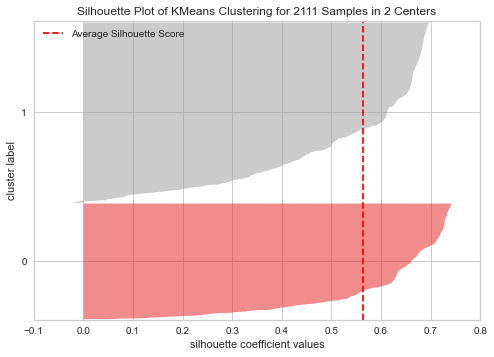

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2111 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
kmeans_scaled = KMeans(n_clusters=2, random_state=0).fit(df)
silhouette = SilhouetteVisualizer(kmeans_scaled)
labels = kmeans_scaled.labels_
print("Silhouette Score:",metrics.silhouette_score(df, labels))
silhouette.fit(df)       
silhouette.show() 

In [18]:
df_normalized = normalize(df)
df_normalized = pd.DataFrame(df_normalized)

In [19]:
pca = PCA(n_components = 2)
df_principal = pca.fit_transform(df_normalized)
df_principal = pd.DataFrame(df_principal)
df_principal.columns = ['XO', 'X1']

In [20]:
def draw_clusters(X, y=None, centers=None, cluster_size=10000):
    _, ax = plt.subplots(figsize=(10, 10))
    
    if y is not None:
        cm = {c: f"C{c}" for c in np.unique(y)}
        colors = [cm[i] for i in y]
    else:
        cm = None
        colors = "b"
    
    ax.scatter(X.iloc[:,0], X.iloc[:,1], color=colors)
    if centers is not None:
        colors = [cm[i] for i in range(len(centers))] if cm else "b"
        ax.scatter(
            centers[:,0], centers[:,1], marker="o", 
            c=colors, alpha=0.25, s=cluster_size
        )
    
    ax.set_xlabel("$X_0$")
    ax.set_xticks([])
    ax.set_ylabel("$X_1$")
    ax.set_yticks([])
    
    return ax

### Agglomerative Clustering

Silhouette Score: 0.5001877983321673


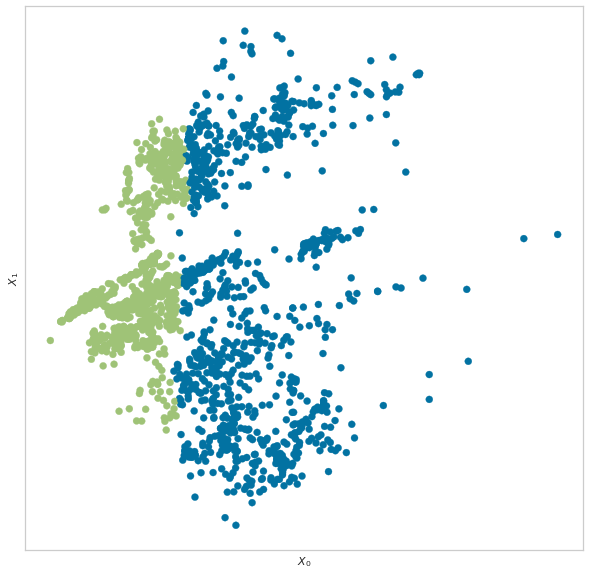

In [21]:
model = AgglomerativeClustering(n_clusters=2)
y = model.fit_predict(df_principal)
draw_clusters(df_principal, y)
labels = model.labels_
print("Silhouette Score:",metrics.silhouette_score(df_principal, labels))

Silhouette Score: 0.3424470485448794


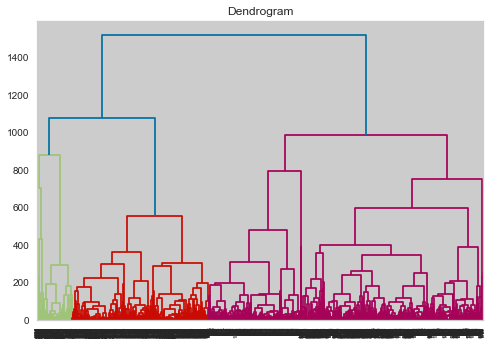

In [22]:
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage

dist_matrix = pairwise_distances(df, metric='euclidean')

model = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='average')
y = model.fit_predict(dist_matrix)
print("Silhouette Score:",metrics.silhouette_score(df, labels))

linked = linkage(dist_matrix, 'average')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

### Spectral Clustering

In [23]:
from sklearn.cluster import SpectralClustering

for n_neighbors in [20, 30, 40, 50, 60, 70, 80]:
    spectral = SpectralClustering(n_clusters=2, random_state=0, affinity='nearest_neighbors', n_neighbors=n_neighbors)
    labels = spectral.fit_predict(df)
    silhouette_avg = silhouette_score(df, labels)
    print(f'n_neighbors={n_neighbors}, Silhouette Score: {silhouette_avg}')

n_neighbors=20, Silhouette Score: 0.5329340641330585
n_neighbors=30, Silhouette Score: 0.5647562051303877
n_neighbors=40, Silhouette Score: 0.5648154313472376
n_neighbors=50, Silhouette Score: 0.5648174750380237
n_neighbors=60, Silhouette Score: 0.5647886146505979
n_neighbors=70, Silhouette Score: 0.5649331283188882
n_neighbors=80, Silhouette Score: 0.5649083333548858


Silhouette Score: 0.5649331283188882


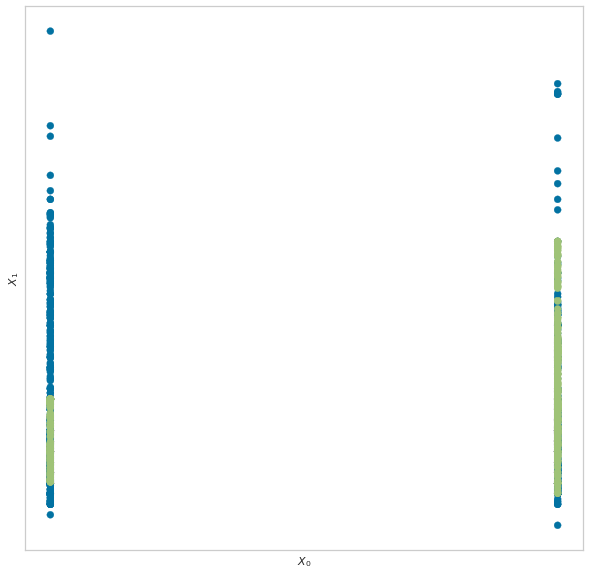

In [24]:
spectral = SpectralClustering(n_clusters=2, random_state=0,
                              affinity='nearest_neighbors', n_neighbors=70)
y = spectral.fit_predict(df)
draw_clusters(df, y)
labels = spectral.labels_
print("Silhouette Score:",metrics.silhouette_score(df, labels))

### DBSCAN

In [25]:
from sklearn.cluster import DBSCAN
help(DBSCAN)

Help on class DBSCAN in module sklearn.cluster._dbscan:

class DBSCAN(sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
 |  
 |  Perform DBSCAN clustering from vector array or distance matrix.
 |  
 |  DBSCAN - Density-Based Spatial Clustering of Applications with Noise.
 |  Finds core samples of high density and expands clusters from them.
 |  Good for data which contains clusters of similar density.
 |  
 |  Read more in the :ref:`User Guide <dbscan>`.
 |  
 |  Parameters
 |  ----------
 |  eps : float, default=0.5
 |      The maximum distance between two samples for one to be considered
 |      as in the neighborhood of the other. This is not a maximum bound
 |      on the distances of points within a cluster. This is the most
 |      important DBSCAN parameter to choose appropriately for your data set
 |      and distance function.
 |  
 |  min_sam

In [26]:
dbscan = DBSCAN(eps=0.5)
y = dbscan.fit_predict(df)
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of clusters: %d" % n_noise_)

print("Silhouette Score:",metrics.silhouette_score(df, labels))


Estimated number of clusters: 20
Estimated number of clusters: 1828
Silhouette Score: -0.5530952484773616


### Reducing dimensionality to try to improve performance

-  Using PCA to determine which features are most important and then trying to reduce number of features to improve performance

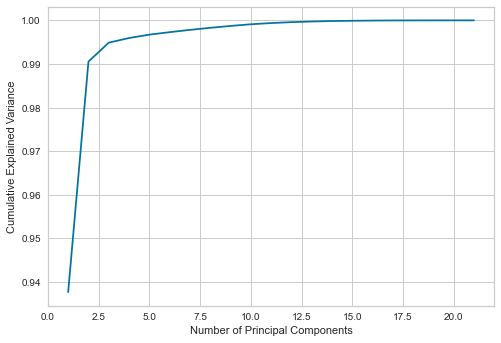

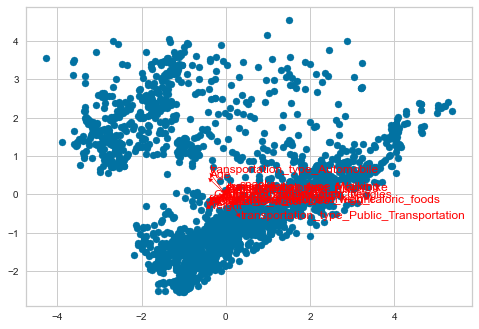

In [27]:
pca = PCA()
pca.fit(df)

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

scaler = StandardScaler()
df_standardized = scaler.fit_transform(df)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_standardized)

fig, ax = plt.subplots()
ax.scatter(pca_result[:, 0], pca_result[:, 1])

for i, feature in enumerate(df.columns):
    ax.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], head_width=0.1, head_length=0.1, fc='red', ec='red')
    ax.text(pca.components_[0, i]*1.2, pca.components_[1, i]*1.2, feature, color='red')

plt.show()

The first graph showing cumulative explained variance sharply increases until it plateaus around 2.5. It seems like only a few features (around 2 or 3) are determining the majority of variance in our dataset. The second graph shows that transportation_type_Automoblie, Age, and transportation_type_Public_Transportation seem to have the largest impact. 

It's interesting that two of the main features contributing to variance are derived from the same original variable, public transportation. Will model performance improve if we reduce the dataset to those variables?

In [41]:
reduced_features = ['transportation_type_Automobile','Age','transportation_type_Public_Transportation']
X = df[reduced_features]

In [42]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(X) 
labels = k_means.labels_
print("Silhouette Score:",metrics.silhouette_score(X, labels))

Silhouette Score: 0.6838290628973298


In [43]:
agglomerative = AgglomerativeClustering(n_clusters=2)
y = agglomerative.fit_predict(X)
labels = agglomerative.labels_
print("Silhouette Score:",metrics.silhouette_score(X, labels))

Silhouette Score: 0.6820781069278852


In [44]:
spectral = SpectralClustering(n_clusters=2, random_state=0,
                              affinity='nearest_neighbors', n_neighbors=70)
y = spectral.fit_predict(X)
labels = spectral.labels_
print("Silhouette Score:",metrics.silhouette_score(X, labels))

Silhouette Score: 0.5469544272013784


In [32]:
dbscan = DBSCAN(eps=0.5)
y = dbscan.fit_predict(X)
labels = dbscan.labels_
print("Silhouette Score:",metrics.silhouette_score(X, labels))

Silhouette Score: -0.4245007935283036


This result is really interesting, especially since public transportation seems to have a larger impact on cluster determination than other variables we might suspect, like weight. This model may hint that differences in weight, obesity level and other factors are in part determined by whether someone lives in a rural/suburban area or a city. To me, that seems like the biggest determinant of transportation type.